Import statements and LaTeX parameters:

In [191]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh_tridiagonal
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Rectangle, Ellipse
from tqdm import tqdm
from matplotlib import cm
import warnings
from sympy import symbols, I, sqrt, limit, factorial, series, eye
from sympy.physics.matrices import msigma

latex_base_font_size = 10
caption_font_size = 9

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": latex_base_font_size,
    "text.latex.preamble": r"""
        \usepackage{amsmath,amssymb}
        \usepackage{bm}
    """,
})


Fig. 1:

In [ ]:
p = dict(left_x=0.25, right_x=0.75,
         top_y=0.50, bottom_y=0.375,
         cap_gap=0.03, cap_plate_h=0.02,
         jj_size=0.03, outer_y=0.625,
         volt_r=0.04, dashed_left=0.2, box_bottom=0.325,
         c_margin=0.0075, label_offset=0.035)

fig, ax = plt.subplots(figsize=(3.4, 1.7))

mid_x = (p['left_x'] + p['right_x'])/2
vline = lambda x,y0,y1,**k: ax.plot([x,x],[y0,y1],color='black',lw=1,**k)
hline = lambda x0,x1,y,**k: ax.plot([x0,x1],[y,y],color='black',lw=1,**k)

cl, cr = mid_x - p['cap_gap']/2, mid_x + p['cap_gap']/2

for x in (p['left_x'], p['right_x']): vline(x,p['bottom_y'],p['top_y'])
hline(p['left_x'], cl, p['top_y'])
hline(cr, p['right_x'], p['top_y'])
for x in (cl, cr): vline(x,p['top_y']-p['cap_plate_h'],p['top_y']+p['cap_plate_h'])
hline(p['left_x'], cl, p['bottom_y'])
ax.plot([cl, cr],[p['bottom_y']+p['jj_size']/2,p['bottom_y']-p['jj_size']/2],'k',lw=1)
ax.plot([cl, cr],[p['bottom_y']-p['jj_size']/2,p['bottom_y']+p['jj_size']/2],'k',lw=1)
hline(cr, p['right_x'], p['bottom_y'])

arm_len = p['outer_y'] - p['top_y']
cb = p['top_y'] + (arm_len - p['cap_gap'])/2
for x in (p['left_x'], p['right_x']):
    vline(x, p['top_y'], cb)
    for y in (cb, cb + p['cap_gap']):
        hline(x - p['cap_plate_h'], x + p['cap_plate_h'], y)
    vline(x, cb + p['cap_gap'], p['outer_y'])

hline(p['left_x'], mid_x - p['volt_r'], p['outer_y'])
hline(mid_x + p['volt_r'], p['right_x'], p['outer_y'])
ax.add_patch(Circle((mid_x, p['outer_y']), p['volt_r'], edgecolor='black', facecolor='none', lw=1))

dr = 1 - p['dashed_left']
cap_mid = cb + p['cap_gap']/2
ax.add_patch(Rectangle((p['dashed_left'], p['box_bottom']), dr - p['dashed_left'], cap_mid - p['box_bottom'], fill=False, linestyle='dashed', edgecolor='black', lw=1))
vline((p['dashed_left'] + dr)/2, cap_mid, p['box_bottom'], linestyle='dashed')

ax.text(mid_x, p['outer_y'], r'$n_{\text{g}}$', va='center', ha='center')
ax.text(mid_x - p['label_offset'], p['top_y'] - p['label_offset'], r'$E_\text{C}$', va='center', ha='center')
ax.text(mid_x + p['label_offset'], p['bottom_y'] + p['label_offset'], r'$E_\text{J}$', va='center', ha='center')
ax.text(dr - p['c_margin'], p['box_bottom'] + p['c_margin'], r'$\hat{c}^{}_\text{R}$', va='bottom', ha='right')
ax.text(p['dashed_left'] + p['c_margin'], p['box_bottom'] + p['c_margin'], r'$\hat{c}^{}_\text{L}$', va='bottom', ha='left')

ax.axis('off')
plt.savefig('fig1.pdf', bbox_inches='tight')
plt.show()


Fig. 2:

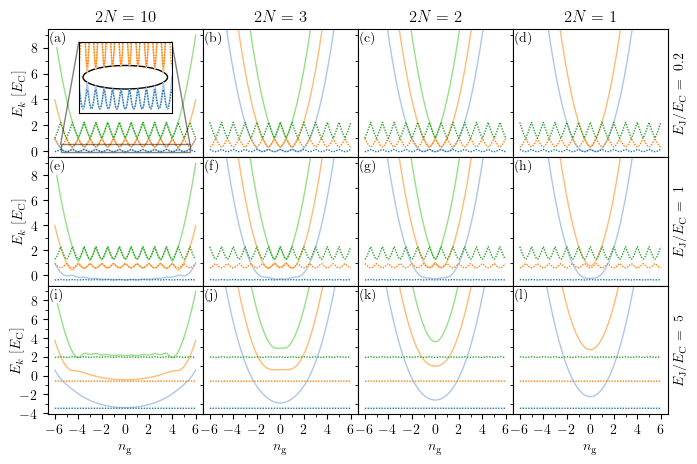

In [4]:
# FIG. 2

# === Data collection ===
session = WolframLanguageSession()
session.start()

def mathieu_a(r, q):
    return np.float64(session.function(wl.MathieuCharacteristicA)(r,q))

def mathieu_E(k, EC, EJ, ng):
    arg = k + 1 - np.mod(k+1, 2) + 2 * abs(np.mod(ng+0.5,1)-0.5)*(-1)**k
    return (EC/4)*mathieu_a(arg, -2*EJ/EC)

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1) - ng)**2
    O = -(EJ/2) * np.sqrt(1 - ((np.arange(-N, N)+0.5)/N)**2)
    eigs = eigh_tridiagonal(D, O, eigvals_only=True, select='i', select_range=(k,k))
    return eigs[0]

def get_ngs_unit_cell(half_nc):
    return np.linspace(0, 1, 2*half_nc, endpoint=False)[1::2]

# Parameters
E_C = 1
E_Js = [0.2, 1, 5]
Ns = [0.5, 1.0, 1.5, 5]
decreasing_Ns = True
if decreasing_Ns: Ns = Ns[::-1]
ks = [0, 1, 2]

half_nc = 100
num_uc = 12
ngs_unit = get_ngs_unit_cell(half_nc)
ngs = np.concatenate([ngs_unit + i for i in range(-num_uc//2, num_uc//2)])

idx = 0 if decreasing_Ns else -1

bands = [[[] for _ in Ns] for _ in E_Js]
mathieu_bands = [[[] for _ in Ns] for _ in E_Js]

for i, EJ in enumerate(E_Js):
    for j, N in enumerate(Ns):
        for k in ks:
            try:
                bands[i][j].append([E(k, E_C, EJ, ng, N) for ng in ngs])
            except:
                bands[i][j].append([np.nan]*len(ngs))
            base_ngs = ngs_unit if N == round(N) else ngs_unit - 0.5
            m_band = [mathieu_E(k, E_C, EJ, ng) for ng in base_ngs]
            mathieu_bands[i][j].append(m_band * num_uc)

session.stop()

# === Figure generation ===
fig, ax = plt.subplots(len(E_Js), len(Ns), figsize=(8,5), sharex=True, sharey='row', gridspec_kw={'hspace':0,'wspace':0})
colors = plt.colormaps["tab20"].colors

for i, EJ in enumerate(E_Js):
    for j, N in enumerate(Ns):
        for k in ks:
            ax[i,j].plot(ngs, bands[i][j][k], lw=1, color=colors[2*k+1])
            ax[i,j].plot(ngs, mathieu_bands[i][j][k], lw=1, ls=(0,(1,1)), color=colors[2*k], dashes=(1,1))
        if (decreasing_Ns and N==Ns[idx]) or (not decreasing_Ns and N==Ns[-1]):
            ymin, ymax = ax[i,j].get_ylim()
        ax[i,j].set_ylim(ymin, ymax)

# Axis ticks and labels
for i in range(len(E_Js)):
    for j in range(len(Ns)):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
for i in range(len(E_Js)):
    for j in range(len(Ns)-1,-1,-1):
        if j==0:
            ticks = [0,2,4,6,8] if i!=2 else [-4,-2,0,2,4,6,8]
            ax[i,j].set_yticks(ticks)
        else:
            ax[i,j].tick_params(axis='y', length=0)

for i in range(len(E_Js)):
    pad = -2.5 if i==2 else None
    ax[i,0].set_ylabel(r'$E_k~[E_\text{C}]$', labelpad=pad)
    ax[i,-1].set_ylabel(rf'$E_\text{{J}}/E_\text{{C}}=~{E_Js[i]}$')
    ax[i,-1].yaxis.set_label_position("right")
    ax[i,0].yaxis.set_minor_locator(ticker.MultipleLocator(1))

for j, N in enumerate(Ns):
    ax[-1,j].set_xlabel(r'$n_\text{g}$')
    ax[-1,j].set_xticks(np.arange(-Ns[idx]-1, Ns[idx]+2, 2))
    ax[-1,j].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax[0,j].set_title(fr'$2N={int(2*N)}$')

for i in range(len(E_Js)):
    for j in range(len(Ns)):
        ax[i,j].text(0.015, 0.9, f'({chr(97+i*len(Ns)+j)})', transform=ax[i,j].transAxes,
                     bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))

# Inset axis zoom
N = Ns[idx]
EJ = E_Js[0]
axins = ax[0,idx].inset_axes([0.2,0.35,0.6,0.55], xlim=[-N-0.5, N+0.5], ylim=[-0.05,0.55])
ax[0,idx].indicate_inset_zoom(axins, edgecolor='black')
axins.plot(ngs, bands[0][idx][0], lw=1, color=colors[1])
axins.plot(ngs, mathieu_bands[0][idx][0], lw=1, ls=(0,(1,1)), color=colors[0])
axins.plot(ngs, bands[0][idx][1], lw=1, color=colors[3])
axins.plot(ngs, mathieu_bands[0][idx][1], lw=1, ls=(0,(1,1)), color=colors[2])
axins.add_patch(Ellipse((0,0.25), width=2*N, height=EJ/E_C, edgecolor='k', facecolor='none', lw=1))

axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel('')
axins.set_ylabel('')

plt.savefig('fig2.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


Fig. 3:

In [ ]:
# FIG. 3

# === Data collection ===
warnings.filterwarnings('ignore')
session = WolframLanguageSession()
session.start()

def mathieu_a(r, q):
    return np.float64(session.function(wl.MathieuCharacteristicA)(r, q))

def mathieu_c(r, q, z):
    return np.float64(session.function(wl.MathieuC)(r, q, z))

def mathieu_s(r, q, z):
    return np.float64(session.function(wl.MathieuS)(r, q, z))

def mathieu_E(k, EC, EJ, ng):
    arg = k + 1 - np.mod(k+1, 2) + 2 * abs(np.mod(ng+0.5, 1) - 0.5) * (-1)**k
    return (EC/4) * mathieu_a(arg, -2*EJ/EC)

def mathieu_psi(k, EC, EJ, ng, theta):
    ng_mod = np.mod(ng + 0.5, 1) - 0.5
    base = np.exp(1j * abs(ng_mod) * theta) / np.sqrt(2*np.pi)
    c_part = mathieu_c(4*mathieu_E(k, EC, EJ, ng)/EC, -2*EJ/EC, theta/2)
    s_part = mathieu_s(4*mathieu_E(k, EC, EJ, ng)/EC, -2*EJ/EC, theta/2)
    psi = base * (c_part + 1j * (-1)**(k+1) * s_part)
    if ng_mod > 0:
        return psi * np.exp(1j * theta * (ng - ng_mod))
    else:
        return np.conj(psi) * np.exp(1j * theta * (ng - ng_mod))

def mathieu_avg_n(k, EC, EJ, ng, ntheta=100):
    thetas = np.linspace(-np.pi, np.pi, ntheta, endpoint=False)
    dtheta = thetas[1] - thetas[0]
    psi = np.array([mathieu_psi(k, EC, EJ, ng, th) for th in thetas])
    dpsi = (np.roll(psi, -1) - np.roll(psi, 1)) / (2*dtheta)
    integrand = np.conj(psi) * dpsi / 1j
    return np.sum(integrand) * dtheta

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1) - ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - n*(n+1))
    eigvals, eigvecs = eigh_tridiagonal(D, O, select='i', select_range=(k,k))
    v = eigvecs[:,0]
    return np.sum(v**2 * np.arange(-N, N+1)) / np.sum(v**2)

# Parameters
E_C = 1
E_J = 0.2
N = 5
num_unit_cells = 12
half_nc = 100

def get_ngs_unit_cell(half_nc):
    return np.linspace(0, 1, 2*half_nc, endpoint=False)[1::2]

ngs_unit_cell = get_ngs_unit_cell(half_nc)
ngs = np.concatenate([ngs_unit_cell + i for i in range(-num_unit_cells//2, num_unit_cells//2)])

# Compute averages
avg_ns = np.array([E(0, E_C, E_J, ng, N) for ng in ngs])
if N == round(N):
    mathieu_base = np.array([mathieu_avg_n(0, E_C, E_J, ng) for ng in ngs_unit_cell])
else:
    mathieu_base = np.array([mathieu_avg_n(0, E_C, E_J, ng-0.5) for ng in ngs_unit_cell])
mathieu_avg_ns = np.concatenate([mathieu_base + i for i in range(-num_unit_cells//2, num_unit_cells//2)])

session.stop()

# === Figure generation ===
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.4, 2.4), gridspec_kw={'hspace': 0})
colors = plt.colormaps["tab20"].colors
dx = ngs[1] - ngs[0]

ax[0].plot(ngs, avg_ns, lw=1, color=colors[1], label=r'$N<\infty$')
ax[0].plot(ngs, mathieu_avg_ns, lw=1, ls='dotted', color=colors[0], label=r'$N\rightarrow\infty$')
ax[0].set_ylabel(r'$\langle \hat{n} \rangle$')
ax[0].set_title(rf'$2N = {2*N}$, $E_\text{{J}}/E_\text{{C}} = {E_J/E_C}$')

ax[1].plot(ngs, np.gradient(avg_ns, dx), lw=1, color=colors[1], label=r'$N<\infty$')
ax[1].plot(ngs, np.gradient(mathieu_avg_ns, dx), lw=1, ls=(0, (1, 1)), color=colors[0], label=r'$N\rightarrow\infty$')

# Analytical derivative overlay
cond = np.abs(ngs) < (N - 0.5)
ax[1].plot(ngs[cond], 2*N*E_C/(E_J * np.sqrt((1+2*N)**2 - 4*ngs[cond]**2)), 'k', lw=1, zorder=-10)

ax[1].set_ylabel(r'$d\langle \hat{n} \rangle/dn_\text{g}$')
ax[1].set_xlabel(r'$n_\text{g}$')
ax[1].set_xticks(np.arange(-N-1, N+2, 2))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))

# Panel labels
ax[0].text(0.01, 0.85, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.01, 0.85, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))

for a in ax:
    a.yaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.savefig("fig3.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


Fig. 4:

In [ ]:
# FIG. 4
def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))
    eigs =  eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k), tol = 1e-14)
    return eigs[0]

### inset data
EC=1
EJ=10**3
N=10**6 / 2
ngs = np.linspace(-N, N, 1000)
freqs = []
for ng in tqdm(ngs):
    freqs.append(E(k=1, EC=EC, EJ=EJ, ng=ng, N=N) - E(k=0, EC=EC, EJ=EJ, ng=ng, N=N))
inset_data = (ngs, freqs)
inset_N = N
inset_EC = EC
inset_EJ = EJ

### main data
EC=1
EJs = np.logspace(1, 2, 100)
exponents = [3,4,5]
EvenTwoNs = np.array([10**k for k in exponents])
Ns = np.concatenate((EvenTwoNs, EvenTwoNs + 1))/2
data = []
dng = 1e-1
for N in tqdm(Ns):
    data_N = []
    for EJ in EJs:
        freq_at_0 = E(k=1,EC=EC,EJ=EJ,ng=0,N=N)-E(k=0,EC=EC,EJ=EJ,ng=0, N=N)
        freq_at_dng = E(k=1,EC=EC,EJ=EJ,ng=dng,N=N)-E(k=0,EC=EC,EJ=EJ,ng=dng, N=N)
        curvature = 2*(freq_at_dng - freq_at_0) / dng**2
        asymptote=2*EC**2*np.sqrt(EJ)*(3*EJ*N-2*EC*N**3)/(EJ+2*EC*N**2)**(5/2)
        asymptote = 4*EC**2*np.sqrt(EJ)*N*(EJ-EC*N**2)/(EJ+2*EC*N**2)**(5/2)
        asymptote = 2*np.sqrt(2*EC*EJ)*(-(1/(2*N))**2)
        asymptote = freq_at_0 / ((N)**2)
        data_N.append(curvature/asymptote)
    data.append(data_N)

fig_width_in_inches = 3.4
fig_height_in_inches = 2.4*2

labels = [rf'$2N=10^{s}$' for s in exponents]
labels += [rf'$2N=10^{s}+1$' for s in exponents]

cmap = cm.get_cmap('coolwarm', len(labels))
colors = [cmap(i) for i in range(len(labels))]
even_colors = colors[0:len(colors)//2]
even_colors.reverse()
odd_colors = colors[len(colors)//2:]
colors = even_colors + odd_colors



fig, ax = plt.subplots(2, figsize = (fig_width_in_inches, fig_height_in_inches), gridspec_kw={'hspace':.4})
ax[0].plot(inset_data[0]/inset_N, inset_data[1]/np.sqrt(2*inset_EC*inset_EJ), color='orange', label='Numerical', lw=1)
ax[0].plot(inset_data[0]/inset_N, (1-(inset_data[0]/(2*inset_N))**2), linestyle = '--', color='k', markersize=3, label = 'Analytical', lw=1)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$n_\mathrm{g}/N$')
ax[0].set_ylabel(r'$\hbar\omega_{\mathrm{q}}~\left[\sqrt{2E_{\mathrm{C}}E_{\mathrm{J}}}\right]$')
ax[0].set_title(r'$2N=10^6,\quad E_\mathrm{J}/E_\mathrm{C} = 10^3$')
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))  # Place minor ticks every 0.1 units
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.125))  # Place minor ticks every 0.1 units

even_handles = []
odd_handles = []

for i, data_N in enumerate(data):
    data_N = np.array(data_N)
    (line,) = ax[1].plot(EJs, data_N, label=labels[i], color=colors[i], lw=1)
    
    if i < len(labels)//2:
        even_handles.append(line)
    else:
        odd_handles.append(line)
    
    # Find the index where data_N is closest to either 0 or 2
    dist_to_0 = np.abs(data_N - 0)
    dist_to_2 = np.abs(data_N - 2)
    dist = np.minimum(dist_to_0, dist_to_2)
    idx = np.argmin(dist)
    
ax[1].plot(EJs, -np.ones_like(EJs)/2, linestyle='--', color='k', lw=1)

legend1 = ax[1].legend(handles=even_handles, loc='lower right', frameon=False, handlelength = 1)
legend2 = ax[1].legend(handles=odd_handles, loc='upper right', frameon=False, handlelength = 1)
ax[1].add_artist(legend1)

ax[1].set_xscale('log')
ax[1].set_ylim(-1.5, 0.5)
ax[1].set_yticks([-1.5, -1, -.5, 0, .5])
ax[1].set_ylabel(r'$\left(d^2\omega_\mathrm{q}/dn_\mathrm{g}^2\right)\left(N^2/\omega_\mathrm{q}\right)\Big|_{n_\mathrm{g}=0}$')
ax[1].set_xlabel(r'$E_\mathrm{J}/E_\mathrm{C}$')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

# put letters in upper left corner of each axis
ax[0].text(0.015, 0.9, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.015, 0.9, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
#plt.show()

ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
plt.savefig('fig4.pdf', bbox_inches='tight')
plt.show()

Fig. 5:

In [ ]:
# FIG. 5
def avg_n(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1, dtype = np.float64)-ng)**2
    n = np.arange(-N, N, dtype = np.float64)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))    
    _, v =  eigh_tridiagonal(D, O, select = 'i', select_range = (k, k), tol = 1e-16)
    return np.sum(np.abs(v[:,0])**2*np.arange(-N, N+1))#/np.sum(np.abs(v[:,0])**2)
def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))
    eigs =  eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k), tol = 1e-14)
    return eigs[0]


### inset data
EC=1
EJ=10**3
N=10**2 / 2
ngs = np.linspace(-2*N, 2*N, 100)
avg_ns = []
for ng in tqdm(ngs):
    avg_ns.append(avg_n(0, EC, EJ, ng, N)/N)
inset_data = (ngs, avg_ns)
inset_N = N
inset_EC = EC
inset_EJ = EJ

### main data

twoNs = np.array([10**2, 10**2+1, 10**3, 10**3+1])

E_Js = np.logspace(1, 2, num=100)

Ns = twoNs / 2
E_C = 1
dng = .1
d3 = lambda N, E_J: (-2 * avg_n(0, E_C, E_J, dng, N) + avg_n(0, E_C, E_J, 2*dng, N)) / dng**3

EC=1
EJs = np.logspace(1, 2, 100)
exponents = [2,3]
EvenTwoNs = np.array([10**k for k in exponents])
Ns = np.concatenate((EvenTwoNs, EvenTwoNs + 1))/2
data = []
dng = 1e-1
for N in tqdm(Ns):
    data_N = [N**4*d3(N, E_J) for E_J in tqdm(E_Js)]
    data.append(data_N)

fig_width_in_inches = 3.4
fig_height_in_inches = 2.4*2

labels = [rf'$2N=10^{s}$' for s in exponents]
labels += [rf'$2N=10^{s}+1$' for s in exponents]

cmap = cm.get_cmap('coolwarm', len(labels))
colors = [cmap(i) for i in range(len(labels))]
even_colors = colors[0:len(colors)//2] 
even_colors.reverse() 
odd_colors = colors[len(colors)//2:]
colors = even_colors + odd_colors

fig, ax = plt.subplots(2, figsize = (fig_width_in_inches, fig_height_in_inches), gridspec_kw={'hspace':.4})
ax[0].plot(inset_data[0]/inset_N, inset_data[1], color='orange', label='Numerical', lw=1)
ax[0].plot(inset_data[0]/inset_N, (inset_data[0] - (inset_EJ/(4*inset_EC*inset_N**4))*inset_data[0]**3)/inset_N, linestyle = '--', color='k', markersize=3, label = 'Analytical', lw=1)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$n_\mathrm{g}/N$')
ax[0].set_ylabel(r'$\langle\hat{n}\rangle/N$')
ax[0].set_title(r'$2N=10^2,\quad E_\mathrm{J}/E_\mathrm{C} = 10^3$')
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

even_handles = []
odd_handles = []

for i, data_N in enumerate(data):
    data_N = np.array(data_N)
    (line,) = ax[1].plot(EJs, data_N, label=labels[i], color=colors[i], lw=1)
    
    if i < len(labels)//2:
        even_handles.append(line)
    else:
        odd_handles.append(line)
    
    # Find the index where data_N is closest to either 0 or 2
    dist_to_0 = np.abs(data_N - 0)
    dist_to_2 = np.abs(data_N - 2)
    dist = np.minimum(dist_to_0, dist_to_2)
    idx = np.argmin(dist)
    
ax[1].plot(E_Js, (-(3/2)*(E_Js/E_C)), linestyle='--', color='k', lw=1)

legend2 = ax[1].legend(handles=(odd_handles+even_handles), loc='upper right', frameon=False, handlelength = 1)

ax[1].set_xscale('log')
ax[1].set_ylim((-3/2)*100, (3/2)*100)
ax[1].set_ylabel(r'$\left(d^3\langle\hat{n}\rangle/dn_\mathrm{g}^3\right)\left(N^4\right)\Big|_{n_\mathrm{g}=0}$')#, labelpad = 0)
ax[1].set_xlabel(r'$E_\mathrm{J}/E_\mathrm{C}$')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(20))  # Place minor ticks every 0.25 units

# put letters in upper left corner of each axis
ax[0].text(0.015, 0.9, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.015, 0.9, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
#plt.show()

ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
plt.savefig('fig5.pdf', bbox_inches='tight')#, pad_inches=0)
plt.show()


Eqs. (13) and (17):

Eqs. (7) and (14):

In [218]:
from sympy.physics.matrices import msigma
from sympy import eye, sqrt
sx = msigma(1)
sz = msigma(3)
n_f, n_c, E_C, E_J, n_g, N = symbols("n_f, n_c, E_C, E_J, n_g, N")
n = eye(2)*(n_f+n_c)/2 + (n_f-n_c)/2 * sz
H=E_C*(n - eye(2)*n_g)**2 - (E_J/(2*N))*sqrt(N*(N+1)-n_f*n_c)*sx

# === Eq. (7) ===
eigenvalues = list(H.eigenvals().keys())
freq = (eigenvalues[1] - eigenvalues[0]).subs(n_f,n_g-1/2).subs(n_c, n_g+1/2).simplify()
print('Cooper pair box frequency times Plancks constant:')
display(freq)

# === Eq. (14) ===
ground = H.eigenvects()[0][2][0]
suscept = (ground.dot(n @ ground)/(ground.dot(ground))).diff(n_g).subs(n_f, n_g-1/2).subs(n_c, n_g+1/2).simplify()
print('Cooper pair box dimensionless charge susceptibility:')
display(suscept)

Cooper pair box frequency times Plancks constant:


sqrt(E_J**2*(N**2 + N - n_g**2 + 0.25))/N

Cooper pair box dimensionless charge susceptibility:


4.0*E_C*N*sqrt(E_J**2*(N**2 + N - n_g**2 + 0.25))/(E_J**2*(4.0*N**2 + 4.0*N - 4.0*n_g**2 + 1.0))

In [217]:
# === Contraction algorithm for evaluation of vacuum expectation values ===

def pairwise_product(term1, term2):
    result = []
    for (coeff1, bstring1) in term1:
        for (coeff2, bstring2) in term2:
            result.append((coeff1*coeff2, bstring1+bstring2))
    return result

def product(terms):
    if len(terms) == 1:
        return terms[0]
    else:
        return product([pairwise_product(terms[0], terms[1]), ] + terms[2:])

# 0 is b, 1 is b^\dagger
def contract(worklist):
    worklist = worklist.copy()
    result = []
    while worklist:
        coeff, bstring = worklist.pop()
        if bstring == "":
            result.append(coeff)
        elif bstring[-1] == "0" or bstring[0] == "1":
            continue
        else:
            index = bstring.find("01")
            before = bstring[:index]
            after = bstring[index+2:]
            worklist.append((coeff, before+after))
            worklist.append((coeff, (before+"10"+after)))
    return sum(result)

def scale(op, scalar):
    return product([op, [(scalar, "")]])

# === Affine Bogoliubov transformation given by Eq. (12) and surrounding discussion ===

n_g, N, E_J, E_C = symbols("n_g N E_J E_C", positive = True)
u_s, u_p, u_m, u_0 = symbols("u_s, u_p, u_m u_0")
b = [(1,"0")]
bd = [(1,"1")]
a = [(u_p, "0"), (-u_m, "1"), (I * u_0 * u_s, "")]
ad = [(u_p, "1"), (-u_m, "0"), (-I * u_0 * u_s, "")]
p = scale(a + scale(ad, -1), 1/(I*sqrt(2)))
pp = p + [(-n_g/sqrt(N), "")]

eps = sqrt(2*E_C*E_J + E_J**2/N**2)
u_p_sub = (E_J + N * eps) / sqrt(4 * N * eps * E_J)
u_m_sub = (E_J - N * eps) / sqrt(4 * N * eps * E_J)
u_0_sub = n_g * sqrt(2 * E_C**2 * E_J / eps**3)
u_s_sub = u_p_sub + u_m_sub

# === Eq. (13) ===
freq = eps - (E_C/2)*(contract(product([b, pp, ad, p, a, bd])) - contract(product([pp, ad, p, a])))
freq = freq.subs({u_p: u_p_sub, u_m: u_m_sub, u_0: u_0_sub, u_s: u_s_sub, }).simplify()
assert((freq - series(freq, n_g, 0, 3)).simplify()==0)
assert(freq.diff(n_g).subs(n_g,0)==0)
freq_0 = limit(freq.subs(n_g, 0).subs(N, x * E_J/E_C), x, "oo")
freq_2 = limit((N**2 * (freq.diff(n_g, 2)/2).subs(n_g, 0)).subs(N, x * E_J/E_C), x, "oo")*(n_g/N)**2
freq = (limit(((freq_0+freq_2)/sqrt(E_C * E_J)).subs(E_C, x * E_J), x, 0) * sqrt(E_C * E_J)).simplify()
print('Transmon qubit frequency times Plancks constant:')
display(freq)

# === Eq. (17) ===
zeroth_order = (sqrt(N)*contract(p))
first_order = ((-1/(4*sqrt(N)))*contract(product([ad, p, a])))
for k in range(1,5):
    first_order += E_C*sqrt(N)/(2*eps*k*factorial(k)) * contract(product([p] + [bd] * k)) * (contract(product([b] * k + [pp, ad, p, a])) + contract(product([b] * k + [ad, p, a, pp])))
all_orders = (zeroth_order + first_order).subs({u_p: u_p_sub, u_m: u_m_sub, u_0: u_0_sub, u_s: u_s_sub}).simplify()
all_orders.diff(n_g, 3).subs(n_g, 0).simplify()
suscept = all_orders.diff(n_g)
assert((suscept - series(suscept, n_g, 0, 3)).simplify() == 0)
assert(suscept.diff(n_g).subs(n_g, 0) == 0)
suscept_0 = limit(suscept.subs(n_g, 0).subs(N, x * E_J/E_C), x, "oo")
suscept_2 = limit((N**4 * (suscept.diff(n_g, 2)/2).subs(n_g, 0)).subs(N, x * E_J/E_C), x, "oo")*(n_g**2)/(N**4)
suscept = suscept_0 + suscept_2
print('Transmon dimensionless charge susceptibility:')
display(suscept.simplify())


Transmon qubit frequency times Plancks constant:


sqrt(2)*sqrt(E_C)*sqrt(E_J)*(N**2 - n_g**2/4)/N**2

Transmon dimensionless charge susceptibility:


1 - 3*E_J*n_g**2/(4*E_C*N**4)